In [1]:
import tensorflow as tf
tf.__version__

2022-05-26 11:34:34.626722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 11:34:34.626736: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.9.1'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 190s 1us/step


In [17]:
x_train = x_train / 255.
x_test = x_test / 255.

In [18]:
x_train.shape

(50000, 32, 32, 3)

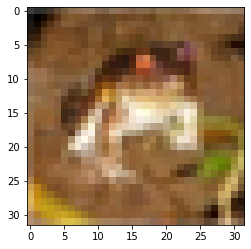

In [20]:
plt.imshow(x_train[0])

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.mean_squared_error,
    metrics="acc",
)

In [46]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=x_train[0].shape),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.mean_squared_error,
    metrics="acc",
)

In [52]:
model.fit(
    x_train, y_train,
    epochs=50,
    validation_data=(x_test,y_test)
)

Epoch 1/50
1563/1563 [==============================] - 68s 43ms/step - loss: 27.6101 - acc: 0.0980 - val_loss: 27.6100 - val_acc: 0.0958
Epoch 2/50
1563/1563 [==============================] - 67s 43ms/step - loss: 27.6101 - acc: 0.0978 - val_loss: 27.6100 - val_acc: 0.0936
Epoch 3/50
1563/1563 [==============================] - 66s 42ms/step - loss: 27.6101 - acc: 0.0940 - val_loss: 27.6100 - val_acc: 0.1071
Epoch 4/50
1563/1563 [==============================] - 67s 43ms/step - loss: 27.6101 - acc: 0.1079 - val_loss: 27.6100 - val_acc: 0.1066
Epoch 5/50
1563/1563 [==============================] - 69s 44ms/step - loss: 27.6101 - acc: 0.1055 - val_loss: 27.6100 - val_acc: 0.1065
Epoch 6/50
1563/1563 [==============================] - 70s 45ms/step - loss: 27.6101 - acc: 0.1066 - val_loss: 27.6100 - val_acc: 0.1072
Epoch 7/50
1563/1563 [==============================] - 71s 46ms/step - loss: 27.6101 - acc: 0.1064 - val_loss: 27.6100 - val_acc: 0.1067
Epoch 8/50
1563/1563 [============

KeyboardInterrupt: 

In [53]:
y_pred = model.predict(x_test)

313/313 [==============================] - 4s 11ms/step


In [54]:
y_pred_max = []
for y in y_pred:
    y_pred_max.append(np.argmax(y))

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_max)

0.1088

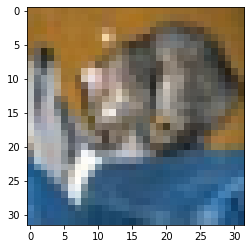

In [43]:
plt.imshow(x_test[0])

In [13]:
## surrogate data

surr_labels = [0, 7]

# find indexes that are not selected_labels
surr_indices_train = set(np.where(y_train)[0])
surr_indices_test = set(np.where(y_test)[0])
for label in surr_labels:
    surr_indices_train = surr_indices_train.intersection(set(np.where(y_train != label)[0]))
    surr_indices_test = surr_indices_test.intersection(set(np.where(y_test != label)[0]))
    
y_train_surr = y_train[list(surr_indices_train)]
x_train_surr = x_train[list(surr_indices_train)]

y_test_surr = y_test[list(surr_indices_test)]
x_test_surr = x_test[list(surr_indices_test)]


In [14]:
# verify all surr_labels are removed
for label in surr_labels:
    print(np.where(y_train_surr == label))
    print(np.where(y_test_surr == label))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [15]:
# train attack model
model_attack = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_attack.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_attack.fit(
    x_train_surr, y_train_surr,
    epochs=5,
    validation_data=(x_test_surr,y_test_surr)
)

Epoch 1/5
1495/1495 [==============================] - 2s 1ms/step - loss: 0.2490 - sparse_categorical_accuracy: 0.9273 - val_loss: 0.1363 - val_sparse_categorical_accuracy: 0.9578
Epoch 2/5
1495/1495 [==============================] - 1s 964us/step - loss: 0.1087 - sparse_categorical_accuracy: 0.9674 - val_loss: 0.0880 - val_sparse_categorical_accuracy: 0.9711
Epoch 3/5
1495/1495 [==============================] - 1s 962us/step - loss: 0.0725 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.0800 - val_sparse_categorical_accuracy: 0.9723
Epoch 4/5
1495/1495 [==============================] - 1s 977us/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.0738 - val_sparse_categorical_accuracy: 0.9761
Epoch 5/5
1495/1495 [==============================] - 1s 976us/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.0771 - val_sparse_categorical_accuracy: 0.9765
